# FRB 20220121aaat

In [6]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, sgram_fn, gauss_norm, gauss_norm3
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

#from burstfit.utils.functions import gauss_norm2, pulse_fn_vec, sgram_fn_vec 
%matplotlib inline 


# input variables 
candidate = '220121aaat'
datestring = '2022_1_21_5_1_21'
beam = 100 
corr = 'corr02'
dm_heimdall = 313.4
width_heimdall = 8 
snr_heimdall = 9.4 
mask_chans=[] 

fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
save_name = candidate + '_beam_'+str(beam)
save_dir = '/home/ubuntu/gechen/burstfit_tests_outputs/' 


#data = ff.proc_cand_fil(fil_file, dm, width, nfreq_plot=64, ndm=64)[0]
#data_t = data.mean(0)

logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)
# create burst object 
bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
)

bd.prepare_data()

# number of channels after binning 
# requires each channel bin to have SNR_min 
# snr_heimdall was calculated with all 256 channels binned into one 
SNR_min = 3 
n_per_bin = int(256 / (snr_heimdall / SNR_min)**2) 
if not math.log(n_per_bin, 2).is_integer():
    n_per_bin = 2 ** (int(np.log2(n_per_bin))+1)
nfreq = int(256 / n_per_bin) 
print(nfreq)
    
# read in data 
data = ff.proc_cand_fil(fil_file, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
# zoom in close to the burst 
data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
#data_burst = data 
    
# fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0, -np.inf),(np.inf, 0.55, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False
)

print('bf.ncomponents=%d'%bf.ncomponents)
print(data_burst)

# Some setting up before we do the fitting 
bf.validate()
bf.precalc()

bf.fitcycle(plot=True)
# fit all componnts 
bf.fitall(plot=False) 
bf.calc_redchisq()
plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
                 bf.tsamp, bf.fch1, bf.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf.sgram_params['all'][1]['popt'][-1], bf.sgram_params['all'][1]['perr'][-1]



2022-02-15 21:00:11,686 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-02-15 21:00:11,791 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-02-15 21:00:11,794 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-02-15 21:00:11,810 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (32.94796335893984, 22.55808984402352)


8


KeyboardInterrupt: 

2022-02-15 19:12:19,814 - model -burstfit.fit - INFO - Making model.
2022-02-15 19:12:19,818 - model -burstfit.fit - INFO - Found 1 components.


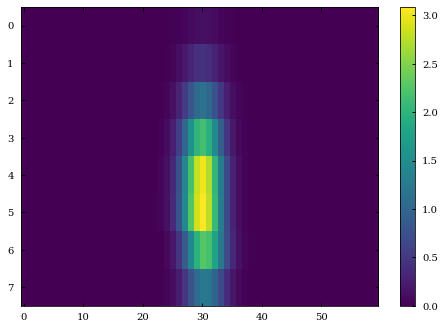

expected despersion in tsamp: 1.4 time samples


2022-02-15 19:12:20,072 - model -burstfit.fit - INFO - Making model.
2022-02-15 19:12:20,074 - model -burstfit.fit - INFO - Found 1 components.


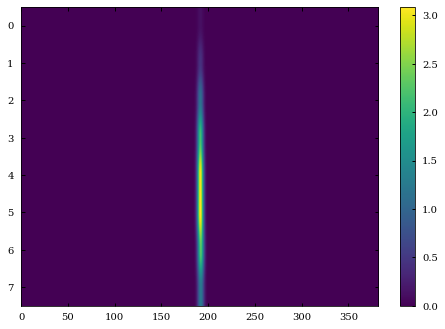

7

In [2]:
bf.sgram_params
plot_me(bf.model[:,int(382/2-30): int(382/2+30)]) 
bd.tsamp*3*1e3

dm_diff = 103.46597098341815 - 103
print('expected despersion in tsamp: %.1f time samples'%(4.149e3*dm_diff*(1/1280**2 - 1/1530**2) / bd.tsamp)) 

plot_me(bf.model)

bf.sgram_params

sgramModel.nparams


In [3]:
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)

# For spectra, we will use a normalized gaussian model  
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])


bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False
)

print(np.shape(data_burst))

# Some setting up before we do the fitting 
bf.validate()
bf.precalc()
print('bf.ncomponents=%d'%bf.ncomponents)


(8, 382)
bf.ncomponents=0


In [4]:
bf.fitcycle(plot=False)
print('bf.ncomponents=%d'%bf.ncomponents)

# fit all componnts 
bf.fitall(plot=False) 
print('bf.ncomponents=%d'%bf.ncomponents)

bf.sgram_params

2022-02-15 19:12:20,317 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-02-15 19:12:20,319 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-02-15 19:12:20,349 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-02-15 19:12:20,352 - initial_profilefit -burstfit.fit - INFO - S: 76.96159895259306 +- 9.17774715322096
2022-02-15 19:12:20,354 - initial_profilefit -burstfit.fit - INFO - mu_t: 190.77731559296302 +- 0.3122178727459853
2022-02-15 19:12:20,356 - initial_profilefit -burstfit.fit - INFO - sigma_t: 2.267390852689768 +- 0.3122178767197027
2022-02-15 19:12:20,359 - initial_profilefit -burstfit.fit - INFO - tau: 0.24702364318070202 +- 0.0
2022-02-15 19:12:20,362 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-02-15 19:12:20,365 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1
2022-02-15 19:12:20,375 - initial_spect

bf.ncomponents=1


2022-02-15 19:12:20,567 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-02-15 19:12:20,569 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-02-15 19:12:20,573 - tests -root - INFO - P values: T-test (0.09416), Kruskal (0.05659), KS (0.04541), F-test (0.36453)
2022-02-15 19:12:20,574 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-02-15 19:12:20,578 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00007), F-test (0.00284)
2022-02-15 19:12:20,580 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-02-15 19:12:20,584 - tests -root - INFO - P values: T-test (0.00068), Kruskal (0.01032), KS (0.15929), F-test (0.00769)
2022-02-15 19:12:20,586 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-02-15 19:12:20,588 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-02-15 19:12:20,620 - initial_profilefi

bf.ncomponents=1


{1: {'popt': [4.572868830989426,
   1.802882279521539,
   85.41194942030705,
   190.9262077859834,
   2.36607547896818,
   0.2536628625872551,
   313.3802149839008],
  'perr': array([2.29172461e-01, 1.92746160e-01, 1.39529080e+01, 7.09304024e-01,
         1.27129174e-02, 1.69322194e-02, 5.14810069e-01])},
 'all': {1: {'popt': [4.572868830989426,
    1.802882279521539,
    85.41194942030705,
    190.9262077859834,
    2.36607547896818,
    0.2536628625872551,
    313.3802149839008],
   'perr': array([2.29172461e-01, 1.92746160e-01, 1.39529080e+01, 7.09304024e-01,
          1.27129174e-02, 1.69322194e-02, 5.14810069e-01])}}}

In [5]:
# MCMC 
# nwalker >= dimention + 1 
# nstep until getting smooth parameter distributions 
mcmc_kwargs = {}
mcmc_kwargs = {'nwalkers':60, 'nsteps':int(1e4),
           'skip':500, 'ncores':4, 
           'start_pos_dev':0.01,
           'prior_range':0.8, 
           'save_results':True,
           'outname':'test_file'}

bf.run_mcmc(plot=True, **mcmc_kwargs)



2022-02-15 19:12:21,085 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-02-15 19:12:21,089 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [4.57286883e+00 1.80288228e+00 8.54119494e+01 1.90926208e+02
 2.36607548e+00 2.53662863e-01 3.13380215e+02]
2022-02-15 19:12:21,101 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-02-15 19:12:21,103 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-02-15 19:12:21,105 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-02-15 19:12:21,107 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(0.45659315265705924) + max_sigma_t_prior(4.2589358621427245))
2022-02-15 19:12:21,109 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior to 500*max(ts)*max_sigma_t_p

IndexError: Index (0) out of range for empty dimension

In [ ]:
# save fitting results 
bd.prepare_data()
bio = BurstIO(bf, bd)
d = bio.save_results(outname=save_name+"_fit_results.json", outdir=save_dir)  

In [ ]:
# do not delete this cell. 
# fit again using the new DM result dm_fit
# data, datadm, tsdm0, dms, datadm0 = ff.proc_cand_fil(fil_file, dm_fit, bd.width, nfreq_plot=nfreq, ndm=32)
# data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)]
# bf.sgram = data_burst
# bf.dm = dm_fit
# bd.dm = dm_fit 

# plt.plot(range(len(data_burst.mean(0))), data_burst.mean(0))
# plt.xlabel('Time Sample using new DM')

# bf.fitall(plot=False)
# plot_fit_results(bf.sgram, bf.sgram_model.evaluate, bf.sgram_params['all'][1]['popt'], 
#                  bf.tsamp, bf.fch1, bf.foff, show=True, save=True, outname=save_name+'2d_fit_res'+'_dm_burstfit', outdir=save_dir)


In [ ]:
bf.mcmc_params
d['param_names']

In [14]:
# saving key burst paramters 
mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc = bf.mcmc_params[1]['popt']
mu_f_mcmc_err, sigma_f_mcmc_err, s_mcmc_err, mu_t_mcmc_err, sigma_t_mcmc_err, tau_mcmc_err, dm_mcmc_err = bf.mcmc_params[1]['perr']

t0 = 0.45 + mu_t_mcmc * bd.tsamp
t0_err = [i * bd.tsamp for i in mu_t_mcmc_err] 

width_ms = sigma_t_mcmc * bd.tsamp * 1e3 # in ms
width_ms_err = [i * bd.tsamp for i in sigma_t_mcmc_err] 

# with open(save_dir+save_name+"_fit_key_results.txt") as f:
#     print('mu_f_mcmc, sigma_f_mcmc, s_mcmc, mu_t_mcmc, sigma_t_mcmc, tau_mcmc, dm_mcmc')
#     print(bf.mcmc_params[1]['popt'])
#     print('lower, upper bounds')
#     print(bf.mcmc_params[1]['perr'])

#outname=save_name+"_fit_results.json", outdir=save_dir

In [15]:
rms_res = np.sqrt(sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0)))

rms_res = np.sqrt(sum(data.mean(0)**2) / len(data.mean(0)))

snr = max(bf.model.mean(0)) / rms_res 

2022-01-24 18:12:09,946 - model -burstfit.fit - INFO - Making model.
2022-01-24 18:12:09,949 - model -burstfit.fit - INFO - Found 1 components.


In [16]:
print(np.sqrt(sum(data.mean(0)**2) / len(data.mean(0))))
print(np.sqrt(sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0))))
print(max(data.mean(0)))

0.3548603331333626
0.3286500444810634
1.9220542


In [17]:
sum(bf.residual.mean(0)**2) / len(bf.residual.mean(0))
dm_mcmc
sigma_t_mcmc

0.9567291488430655

In [18]:
data_mcmc_dm = ff.proc_cand_fil(fil_file, dm_mcmc, sigma_f_mcmc, nfreq_plot=nfreq, ndm=32)[0]


In [19]:
#snr_himdall?  
max(data_mcmc_dm.mean(0)) / np.sqrt(sum(data_mcmc_dm.mean(0)**2) / len(data_mcmc_dm.mean(0)))



6.100199784287315

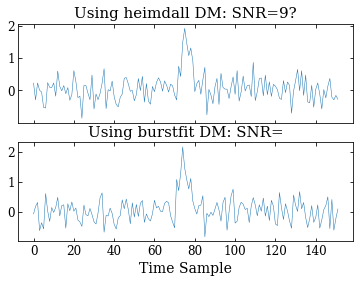

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(range(len(data.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])), data.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])
ax[0].set_title('Using heimdall DM: SNR=%d?'%bd.snr)

ax[1].plot(range(len(data_mcmc_dm.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])), data_mcmc_dm.mean(0)[int(0.48/bd.tsamp): int(0.52/bd.tsamp)])
ax[1].set_xlabel('Time Sample')
ax[1].set_title('Using burstfit DM: SNR=')
fig.savefig(save_name + 'burst.pdf')

In [21]:
bf.mcmc_params

{1: {'popt': [4.708031244884689,
   1.85280016354413,
   90.85737756644824,
   187.8991723270993,
   0.9567291488430655,
   2.2145336012418158,
   314.0674867854782],
  'perr': [[0.24465106023286687, 0.24250744080276831],
   [0.2512486159717484, 0.3158300338000739],
   [12.792131298028593, 14.462276833939455],
   [1.0983315792561825, 1.2984426080577691],
   [0.5072899812359954, 0.6281460277956125],
   [0.7524568552423347, 0.6960233914243763],
   [0.7112840495276487, 0.6506028843043623]]}}

In [22]:
len(data_burst.mean(0))

382